# Expression performance

In [1]:
import iarray as ia
import numpy as np
from time import time
import ctypes
import matplotlib.pyplot as plt
import numexpr as ne
from iarray import udf
from iarray.py2llvm import float64
from numba import config, njit, prange

#omp = ctypes.CDLL('/Users/faltet/miniconda3/lib/libiomp5.dylib')
#omp_set_num_threads = omp.omp_set_num_threads

max_num_threads = 6
nrep = 5

In [2]:
@njit(parallel=True)
def poly_numba(x):
    y = np.empty(x.shape, x.dtype)
    for i in prange(len(x)):
        y[i] = (x[i] - 1.35) * (x[i] - 4.45) * (x[i] - 8.5)
    return y

#config.THREADING_LAYER = 'omp'

@udf.jit
def poly_udf(x: udf.Array(float64, 1), y: udf.Array(float64, 1)):
    n = x.shape[0]
    for i in range(n):
        y[i] = (x[i] - 1.35) * (x[i] - 4.45) * (x[i] - 8.5)
    return 0


In [3]:
# Define array params
shape = [32 * 512 * 1024]
pshape = [512 * 1024]
pshape2 = [16 * 1024]
bshape = pshape2
dtshape = ia.dtshape(shape)
size = int(np.prod(shape))

bstorage = ia.StorageProperties("blosc", pshape, bshape)
pstorage = ia.StorageProperties("plainbuffer", None, None)

eval_flags = ia.EvalFlags(method="auto", engine="auto")

res = []

for num_threads in range(1, max_num_threads + 1):
    print(f"Num. threads: {num_threads}")
    # omp_set_num_threads(num_threads)
    res_i = []
    kwargs = dict(nthreads=num_threads, clib=ia.LZ4)

    # Numpy
    a1 = np.linspace(0, 10, size).reshape(shape)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = eval("(x - 1.35) * (x - 4.45) * (x - 8.5)", {"x": a1})
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # numba
    a1 = np.linspace(0, 10, size).reshape(shape)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = poly_numba(a1)
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Numexpr
    a1 = np.linspace(0, 10, size).reshape(shape)
    t = []
    ne.set_num_threads(num_threads)
    for _ in range(nrep):
        t0 = time()
        b1 = ne.evaluate("(x - 1.35) * (x - 4.45) * (x - 8.5)", local_dict={'x': a1})
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Plainbuffer
    a1 = ia.linspace(dtshape, 0, 10, storage=pstorage, nthreads=num_threads)
    expr = ia.Expr(eval_flags=eval_flags, nthreads=num_threads)
    expr.bind("x", a1)
    expr.bind_out_properties(dtshape, storage=pstorage)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk without compression
    a1 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0, **kwargs)
    expr = ia.Expr(eval_flags=eval_flags, clevel=0, **kwargs)
    expr.bind("x", a1)
    expr.bind_out_properties(dtshape, storage=bstorage)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk with compression
    a1 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=9, **kwargs)
    expr = ia.Expr(eval_flags=eval_flags, clevel=9, **kwargs)
    expr.bind("x", a1)
    expr.bind_out_properties(dtshape, storage=bstorage)
    expr.compile("(x - 1.35) * (x - 4.45) * (x - 8.5)")
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk with compression and UDF
    a1 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=9, **kwargs)
    expr = poly_udf.create_expr([a1], dtshape, storage=bstorage, method="auto", clevel=9, **kwargs)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    res.append(res_i)


Num. threads: 1
Num. threads: 2
Num. threads: 3
Num. threads: 4
Num. threads: 5
Num. threads: 6


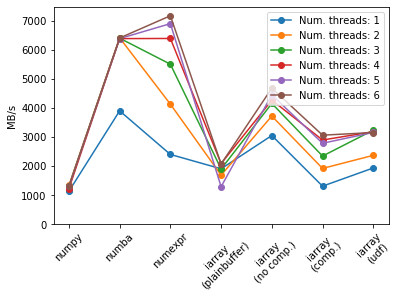

In [4]:
xticks = ("numpy", "numba", "numexpr", "iarray\n(plainbuffer)", "iarray\n(no comp.)", "iarray\n(comp.)", "iarray\n(udf)")
plt.xticks(range(len(xticks)), xticks)
for i in range(0, max_num_threads):
    plt.plot(xticks, res[i], "o-", label=f"Num. threads: {i+1}")
plt.xticks(rotation=45)
plt.ylabel("MB/s")
plt.ylim(0)
plt.legend()
plt.show()